In [ ]:
!pip install python-igraph
!pip install -U simpy
!pip install networkx

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import simpy
import networkx as nx
import math
import random
import warnings
warnings.filterwarnings("ignore")

# 參數設定

## 小世界網絡


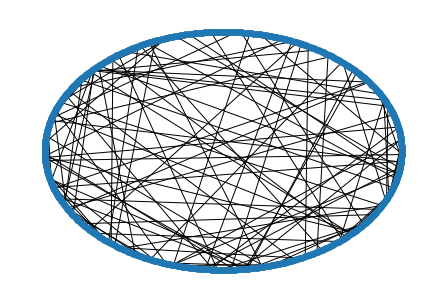

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1
998,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1


In [ ]:
# generate a small world network
import networkx as nx
watts_strogatz = nx.watts_strogatz_graph(1000,4,0.05)
pos = nx.circular_layout(watts_strogatz)          #use　circular
nx.draw(watts_strogatz,pos,with_labels=False,node_size = 30)  #draw
plt.show()
# get network matrix
adj_matrix = nx.adjacency_matrix(watts_strogatz)
adj_matrix.todense()
relation_df = pd.DataFrame(adj_matrix.todense())
relation_df

# Functioal

In [ ]:

def dec_proce_setting():
  df = pd.DataFrame()
  # social opinion (sd 0.1/0.3)
  df['sopn'] = np.random.normal(0.15, 0.1, 1000)
  # social opinion uncertainty (0.05/0.3)
  df['sopn_u'] = 0.3 # no extrem
  # the proportion of extremists in the population
  df['extremists'] = np.random.choice([True, False], 1000, p=[0.15, 0.85])
  # social opinion uncertainty for the extremists
  df.loc[df['extremists'] == True, 'sopn_u'] = 0.01
  df['sopn_u_ex'] = 0.01
  # individual benifit (Initial)
  df['ib'] = np.nan
  # individual benifit uncertainty (Initial)
  df['ib_u'] = np.nan
  df['decision'] = 'Not concerned' # Initial state for everyone
  # whether the individual get the message from the media
  df['get_message_media'] = False
  # whether the individual get the message from its neighbor
  df['get_message_nei'] = False
  # information: This variable expresses whether the individual is able to evaluate his or her individual benefit and transmit the information.
  df['info'] = False
  # rho: reflection time necessary for the adoption decision (Initial)
  df['preadopN'] = 0
  df['receive_time'] = 0
  df['discuss'] = 0
  return df


def gen_interest(df):
  # global opinion
  # If the individual benefit is nil, it is equal to the social opinion.
  # If not, it is the average of the social opinion and the individual benefit
  df['gopn'] = df.apply(lambda x: x['sopn']
                        if math.isnan(x['ib'])
                        else (x['sopn'] + x['ib'])/2,
                        axis=1)
  # global opinion uncertainty
  # If the individual benefit uncertainty is nil, it is equal to the social opinion uncertainty. 
  # If not, it is the average of the social opinion uncertainty and the individual benefit uncertainty.
  df['gopn_u'] = df.apply(lambda x: x['sopn_u']
                          if math.isnan(x['ib_u'])
                          else (x['sopn_u'] + x['ib_u'])/2,
                          axis=1)
  # interest : based on the global opinion and uncertainty.
  df['gop_plus'] = df['gopn'] + df['gopn_u']
  df['gop_minus'] = df['gopn'] - df['gopn_u']
  df['interest'] = 'Maybe'
  df.loc[(df['gop_plus']>0) & (df['gop_minus']>0), 'interest'] = 'Yes'
  df.loc[(df['gop_plus']<0) & (df['gop_minus']<0), 'interest'] = 'No'

  return df

def person_eval(df):
  # personal evaluation
  bbol = (df['decision'] == 'Information request')
  irn = len(df[bbol & (df['info'] == True)])
  # omega: the probability of transmitting the knowledge necessary to the economic evaluation of the measure
  # 0.5
  df.loc[bbol & df['info'] == True, 'evlp'] = np.random.choice(
      [True, False],
      irn,
      p=[0.5, 0.5])
  ebol = (df['evlp'] == True) & (bbol)
  eboln = len(df[ebol])
  # individual benifit
  df.loc[ebol, 'ib'] = np.random.normal(-0.2, 0.1, eboln)
  # individual benifit uncertainty = 0.01
  df.loc[ebol, 'ib_u'] = 0.05

  return df

def check_nc(df):
  ncbol = df['decision'] == 'Not concerned'
  df.loc[ncbol & (df['interest'] == 'No'), 'decision'] = 'Not concerned'
  df.loc[ncbol & (df['interest'] != 'No'), 'decision'] = 'Information request'
  df.loc[ncbol, 'info'] = False

  return df

def check_ir(df):
  irbol = (df['decision'] == 'Information request')
  df.loc[irbol & (df['interest'] == 'No'), 'decision'] = 'Not concerned'
  df2 = person_eval(df)
  # upadate interest
  df3 = gen_interest(df2)
  # check decision state
  ebol = (df3['evlp'].notnull()) & (df3['evlp'] == True) & irbol

  df3.loc[ebol & (df3['interest'] == 'Yes'), 'decision'] = 'Pre-adoption'
  df3.loc[ebol & (df3['interest'] != 'Yes'), 'decision'] = 'No adoption'

  return df3

def check_nad(df):
  nadbol = df['decision'] == 'No adoption'
  df.loc[nadbol & (df['interest'] == 'Yes'), 'decision'] = 'Pre-adoption'

  return df

def check_pad(df):
  padbol = df['decision'] == 'Pre-adoption'
  df.loc[padbol & (df['interest'] != 'Yes'), 'decision'] = 'No adoption'
  df['preadopN'] = df.apply(lambda x: x['preadopN'] + 1
                                if x['decision'] == 'Pre-adoption'
                                else 0,
                                axis=1)
  return df

def check_adot(df):
  df.loc[(df['preadopN'] == 15), 'decision'] = 'Adoption'
  return df

def update_setting(df):
  bol = (df['info'] == False)
  df.loc[bol, 'info'] = np.random.choice([True, False],
                       len(df[bol]),
                       p=[0.5, 0.5])
  return df


In [ ]:
def send_message_nei(df):
    gamma = 0.3

    if timeN == 1:
      df.loc[df['get_message_media'] == True, 'receive_time'] = timeN
      #df.loc[(df['receive_time'] == timeN ) | ((df['receive_time'] + 3 ) < timeN ), 'discuss' ] = 0
    else:       
      # loop for 3 kinds of propagating level
      for tart in [1,2,3]:
        # calculate the value of propagating proportion
        df.loc[df['receive_time'] == timeN - tart, 'discuss' ] = 1 - gamma * tart
        # find out each kinds of propagating level people
        the_chosen_people = df[df['discuss'] == 1 - gamma * tart].index.tolist()
        for tco in the_chosen_people:
          # for each kinds of propagating level people,find out their neighbors
          neighbors = relation_df.index[relation_df[tco] == 1].tolist()
          for nei in neighbors:
            # propagate the message
            df['get_message_nei'][nei] = np.random.choice([True, False], 1, p=[1 - gamma * tart, gamma * tart])[0]
            df.loc[(df['get_message_nei'] == True) & (df['info'] == False), 'info'] = True
      df.loc[df['get_message_media'] == True, 'receive_time'] = timeN
 
    return df

def gen_info(df):
    # the frequency of the media messages 0.004/0.001
    df['get_message_media'] = np.random.choice([True, False], 1000, p=[0.004, 0.996])
    # if get message from media, and information is False, change information into True
    df.loc[(df['get_message_media'] == True) & (df['info'] == False), 'info'] = True
    return df

#relative agreement
def rel_agree(df):
    # set the rate of the dynamics: mu = 1
    mu = 1
    #select one person
    the_chosen_one = np.random.choice(range(0,1000),1)[0]
    #find out its neighbors
    neighbors = relation_df.index[relation_df[the_chosen_one] == 1].tolist()
    #select one neighbor
    itsneighbor = np.random.choice(neighbors,1)[0]
    #print out the chosen one and one of its neighbors
    print(the_chosen_one,itsneighbor)
    #follow the formula of relative agreement model
    x_i=df['sopn'][the_chosen_one]
    u_i=df['sopn_u'][the_chosen_one]
    x_j=df['sopn'][itsneighbor]
    u_j=df['sopn_u'][itsneighbor]
    h_ij=min(x_i+u_i, x_j+u_j) - max(x_i-u_i, x_j-u_j)
    if(h_ij>u_i):
        relagree=(h_ij/u_i)-1
        delta_x_j=mu*relagree*(x_i-x_j)
        delta_u_j=mu*relagree*(u_i-u_j)
        df['sopn'][itsneighbor]=x_j+delta_x_j
        df['sopn_u'][itsneighbor]=u_j+delta_u_j
    return df

In [ ]:
outdflt = []
timeN = 0
while timeN < 500:
  if timeN == 0:
    tt = dec_proce_setting()
  else:
    tt = gen_info(tt)
    tt = send_message_nei(tt)
    tt = rel_agree(tt)
    tt = gen_interest(tt)
    tt = check_nc(tt)
    tt = check_ir(tt)
    tt = check_nad(tt)
    tt = check_pad(tt)
    tt = check_adot(tt)
    tt['tab'] = timeN
    outdflt.append(tt[['tab', 'decision', 'get_message_media', 
              'info', 'interest', 'preadopN',
              'sopn', 'gopn']]
              )
  
  if timeN % 10 == 0:
    print(tt[['interest']].value_counts())
    print(tt[['decision', 'info']].value_counts())
    
    
    
  timeN += 1

KeyError: ignored

In [ ]:
len(outdflt)

141

In [ ]:
outdf = pd.concat(outdflt)
outdf.reset_index(drop=True, inplace=True)
#outdf['tab'] = outdf.index // 1000
outdf

,tab,decision,get_message_media,info,interest,preadopN,sopn,gopn
0,1,Information request,False,False,Yes,0,0.172715,0.172715
1,1,Information request,False,False,Maybe,0,0.267260,0.267260
2,1,Information request,False,False,Maybe,0,0.166958,0.166958
3,1,Information request,False,False,Maybe,0,-0.046815,-0.046815
4,1,Information request,False,False,Maybe,0,0.287663,0.287663
...,...,...,...,...,...,...,...,...
498995,499,No adoption,False,True,Maybe,0,0.152037,0.019311
498996,499,No adoption,False,True,Maybe,0,0.206644,-0.016497
498997,499,Adoption,False,True,Yes,0,0.259664,0.046452
498998,499,No adoption,False,True,No,0,0.046834,-0.152728


In [ ]:
outdf.columns

Index(['decision', 'get_message_media', 'info', 'interest', 'interest',
       'preadopN', 'sopn', 'gopn', 'tab'],
      dtype='object')

In [ ]:
from google.colab import drive
drive.mount('drive', force_remount=True)
outdf.to_csv('fig13.csv')
!cp fig13.csv "drive/My Drive/"

Mounted at drive
